# Hello, _nbpresent_!

In [ ]:
import nbpresent
nbpresent.__version__

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns




# special matplotlib argument for improved plots
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = (15, 10)
sns.set_style("whitegrid")
sns.set_context("poster")


In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
### Imporitng libraries

# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer


In [4]:
df = pd.read_csv("data/train 2.csv")
df.drop('id', axis = 1,inplace = True)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
features = df[['comment_text','toxic']]
features.head(5)

,comment_text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
len(df.toxic)

159571

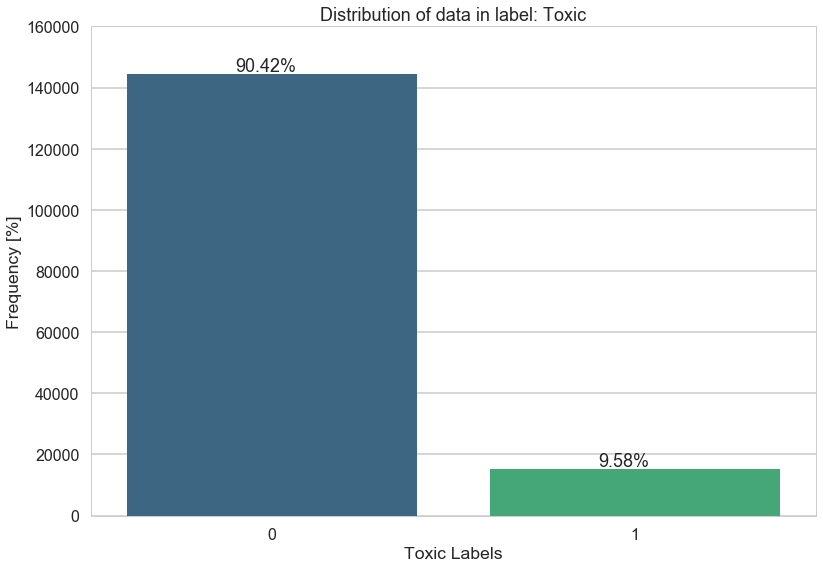

In [7]:
## Distribution of data point in each of these clusters obtained by k-means ++ 

ax = sns.countplot(x = df.toxic ,palette="viridis")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(13,9)
ax.set_ylim(top=160000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(df.toxic)), (p.get_x()+ 0.3, p.get_height()+ 1000))

plt.title('Distribution of data in label: Toxic')
plt.xlabel('Toxic Labels')
plt.ylabel('Frequency [%]')
plt.show()

In [8]:
X = df.comment_text
y = df.toxic

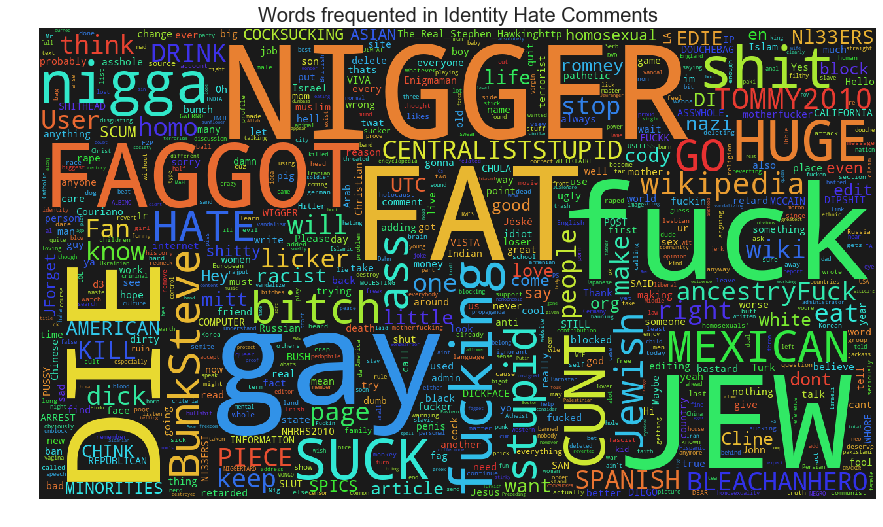

In [57]:
## Identity Hate

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
stopword = set(STOPWORDS)

mask=np.array(Image.open("data/maxresdefault.jpg"))
mask=mask[:,:,1]
df_iden=df[df.identity_hate==1]
text=df_iden.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask= mask, stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Identity Hate Comments", fontsize=20)
plt.imshow(wc.recolor(random_state=123), alpha=0.9)

plt.show()

In [9]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(100 *"_")
print(y_train.value_counts())
print(100 *"_")
print(y_test.value_counts())

(119678,)
(39893,)
(119678,)
(39893,)
____________________________________________________________________________________________________
0    108281
1     11397
Name: toxic, dtype: int64
____________________________________________________________________________________________________
0    35996
1     3897
Name: toxic, dtype: int64


/Users/bobbyvegi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
## Count vectorizer
max_features = 50000
vec = CountVectorizer(max_features= max_features, ngram_range=(1,2), stop_words='english', max_df=0.5)
#X_train_vec  = vec.fit_transform(X_train)


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
### Transforming words into feature vectors
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

#n = train.shape[0]
vec_tfid = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features = max_features)
X_train_vec = vec_tfid.fit_transform(X_train)

In [11]:
# examine the document-term matrix
X_train_vec

<119678x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 11263861 stored elements in Compressed Sparse Row format>

In [12]:

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_vec = vec_tfid.transform(X_test)
X_test_vec

<39893x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 3753568 stored elements in Compressed Sparse Row format>

In [13]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [14]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_vec, y_train)

CPU times: user 109 ms, sys: 17.5 ms, total: 127 ms
Wall time: 129 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [15]:
# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_vec)

In [16]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.94821146567066905

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97     35996
          1       0.91      0.52      0.66      3897

avg / total       0.95      0.95      0.94     39893



In [18]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[35797,   199],
       [ 1867,  2030]])

In [19]:
# print message text for the false positives (Not Toxic incorrectly classified as Toxic)
print(len(X_test[y_test < y_pred_class]))
X_test[y_test < y_pred_class]

199


140466    Wikipedia is like a big playground with kids r...
141317    You are not serious.  You have William S. Jack...
26698     why did you delete my page? \n\nPMDrive1061!\n...
64490     Congratulations \n\nYou got me banned through ...
17146     Gonna get it \n\nYou gonna get it son! 94.2.22...
116478    clearly has no life. Who actually spends all t...
26484     Cougar old, odelay courage cougar! \n\nYou're ...
45333               UNBLOCK ME RIGHT NOW!!!!!!!!!!!!!!!!!!!
73688     Rama stfu and stop stalking me, he keeps delet...
2593      jd2718 the sock fiend \n\nnow hes lying out hi...
156621    "\n\n Adam Rose \n\n  John Cena lover Why do y...
150370    Please\nhttp://ru.wikipedia.org/wiki/%D0%A3%D1...
34218                         beware \n\nyour gonna get it!
106315    hey halbared i didmt know youre a wrestler. p....
102704                      Why did you insult me?!!?!??!?!
118125      I am proud to be a homosexual.  Gay pride 2008!
8933      Some ratings from the VCHip \n

In [20]:
X_test[y_test > y_pred_class]

116638    Bullshit! \n\nThe section used to be a neat li...
89694     You \nDonny Osmond is an arsehole! Let me post...
50963     Vandalism \n\nStop vandalising pages. You are ...
30136     Please refrain from unmaking unconstructive ed...
119339    "\n  \n\nYour request to be unblocked has been...
87562     Stop with the garbage \nI'll say irrelevant as...
105726    Thanks. Also thanks for freezing the article. ...
114979    The Cut-Away Diagram is Shit \n\nI hold two ba...
151371    "\n\nHey MF please don't leave Wiki I totally ...
112140                       Go screw yourself.68.79.88.224
132352                 PURPLE FLYING SPAGETTI BONER MONSTER
110296    MAYBE YOU SHOULD READ OVER YOUR MESSAGES \n\nI...
23496            Who is this stupid boy ? A kiwi, for sure.
148742    are u stil a aids carrier?\nhey amor,\nI was w...
3213      Mark. Your semen is not viable. Were you to pr...
60805             You and Jack greenmaven are MotherFuckers
19827     You hypocrite \n\nEither you a

In [21]:
X_test[77661]

'"\n\n June 2014 \n\nBecause of WP:OUTING I will not say who you were impersonating, but I can\'t see why someone with good intentions would deliberately impersonate another editor, so I\'m hard-blocking you.  \'\'\'\'\'\'頭 "'

In [22]:
# calculate predicted probabilities for X_test_dtm (poorly calibrated)
y_pred_prob = nb.predict_proba(X_test_vec)[:, 1]
y_pred_prob

array([  5.98811758e-01,   6.50136143e-06,   2.78272040e-02, ...,
         6.00737199e-07,   1.52139462e-01,   5.25214946e-05])

In [23]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.95123871930799031

### Logistic Regression

In [24]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [25]:
# train the model using X_train_dtm
%time logreg.fit(X_train_vec, y_train)

CPU times: user 4.53 s, sys: 179 ms, total: 4.7 s
Wall time: 4.8 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(X_test_vec)

In [27]:
# calculate predicted probabilities for X_test_dtm (well calibrated)
y_pred_prob = logreg.predict_proba(X_test_vec)[:, 1]
y_pred_prob

array([ 0.86698903,  0.00149882,  0.03582699, ...,  0.00087354,
        0.37884672,  0.00206868])

In [28]:
# calculate accuracy
metrics.accuracy_score(y_test, y_pred_class)

0.95470383275261328

In [29]:
# calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.97128726460440129

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class))

             precision    recall  f1-score   support

          0       0.96      1.00      0.98     35996
          1       0.93      0.58      0.71      3897

avg / total       0.95      0.95      0.95     39893



### Exploring toxic and not toxic words

In [32]:
# store the vocabulary of X_train
X_train_tokens = vec_tfid.get_feature_names()
len(X_train_tokens)

50000

In [33]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[  1.18589297e+03,   3.14519599e+02,   1.52890379e+02, ...,
          4.99451152e+00,   5.51286585e+00,   5.51286585e+00],
       [  4.08938985e+02,   2.73840945e+02,   1.89204445e+01, ...,
          3.89912022e-01,   0.00000000e+00,   0.00000000e+00]])

In [34]:

# number of times each token appears across all Not toxic messages
Not_Toxic_token_count = nb.feature_count_[0, :]
Not_Toxic_token_count

array([ 1185.89297168,   314.51959907,   152.89037851, ...,     4.99451152,
           5.51286585,     5.51286585])

In [35]:
# number of times each token appears across all Toxic messages
Toxic_token_count = nb.feature_count_[1, :]
Toxic_token_count

array([  4.08938985e+02,   2.73840945e+02,   1.89204445e+01, ...,
         3.89912022e-01,   0.00000000e+00,   0.00000000e+00])

In [36]:
# create a DataFrame of tokens with their separate not toxic and toxic counts
tokens = pd.DataFrame({'token':X_train_tokens, 'Not_toxic':Not_Toxic_token_count, 'Toxic':Toxic_token_count}).set_index('token')
tokens.head()

,Not_toxic,Toxic
token,,
!,1185.892972,408.938985
! !,314.519599,273.840945
"! """,152.890379,18.920444
! ',21.761411,2.697860
! (,64.119350,6.916931


In [37]:
# examine 5 random DataFrame rows
tokens.sample(5, random_state=123)

,Not_toxic,Toxic
token,,
bottom .,4.942353,0.000000
that ',289.928780,25.072778
rules to,6.394032,0.248563
? surely,5.377625,0.000000
nyc,7.791876,0.384010


In [38]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([ 108281.,   11397.])

In [43]:
# add 1 to not toxic and toxic counts to avoid dividing by 0
tokens['Not_toxic'] = tokens.Not_toxic + 1
tokens['Toxic'] = tokens.Toxic + 1
tokens.sample(5, random_state=123)

,Not_toxic,Toxic,spam_ratio
token,,,
bottom .,1.000055,1.000088,1.598833
that ',1.002687,1.002288,0.851456
rules to,1.000068,1.000110,1.604319
? surely,1.000059,1.000088,1.489714
nyc,1.000081,1.000121,1.495613


In [44]:
# convert the ham and spam counts into frequencies
tokens['Not_toxic']  = tokens.Not_toxic  / nb.class_count_[0]
tokens['Toxic']  = tokens.Toxic / nb.class_count_[1]
tokens.sample(5, random_state=123)

,Not_toxic,Toxic,spam_ratio
token,,,
bottom .,0.000009,0.000088,1.598833
that ',0.000009,0.000088,0.851456
rules to,0.000009,0.000088,1.604319
? surely,0.000009,0.000088,1.489714
nyc,0.000009,0.000088,1.495613


In [45]:
# calculate the ratio of toxic to non-toxic for each token
tokens['spam_ratio'] = tokens.Toxic/ tokens.Not_toxic
tokens.sample(10, random_state=123)

,Not_toxic,Toxic,spam_ratio
token,,,
bottom .,0.000009,0.000088,9.501146
that ',0.000009,0.000088,9.497052
rules to,0.000009,0.000088,9.501226
? surely,0.000009,0.000088,9.501108
nyc,0.000009,0.000088,9.501216
on their,0.000009,0.000088,9.500769
his claims,0.000009,0.000088,9.501236
who claim,0.000009,0.000088,9.501388
all due,0.000009,0.000088,9.501443


In [46]:
# examine the DataFrame sorted by spam_ratio
tokens.sort_values('spam_ratio', ascending=False)

,Not_toxic,Toxic,spam_ratio
token,,,
fuck,0.000009,0.000090,9.770254
!,0.000009,0.000091,9.735852
! !,0.000009,0.000090,9.701678
you,0.000009,0.000092,9.692790
fucking,0.000009,0.000089,9.668536
shit,0.000009,0.000089,9.618878
fuck you,0.000009,0.000089,9.607452
ass,0.000009,0.000089,9.594311
suck,0.000009,0.000089,9.592652
